Train samples: 189
Validation samples: 21
Test samples: 42
{
  "messages": [
    "Hello there! What's your general plan for this game? My inclination when I play Austria is to piss off as few people as possible, so I don't plan on making any overtly aggressive moves this turn.",
    "Hi Austria. Nice to meet you, and looking forward to playing as your neighbor. \n\nHmmmm, I hate playing as Italy. I rarely succeed. Frankly, I\u2019ve recently tried early attacks on Austria, as Italy, AND IT KEEPS TURNING OUT POORLY. I\u2019d really like to play this one as a tight-knit Central Trio if you have any appetite for that. Not sure if I should set up a Lepanto or go west, but I\u2019d be happy to hear your thoughts on it.",
    "That sounds good to me. I think probably what would work best is if you and Germany go west while Turkey and I contain and/or eat Russia, then once I've picked up some Russian dots and gotten some good position, you split your fleets to help me take Turkey and help Ger

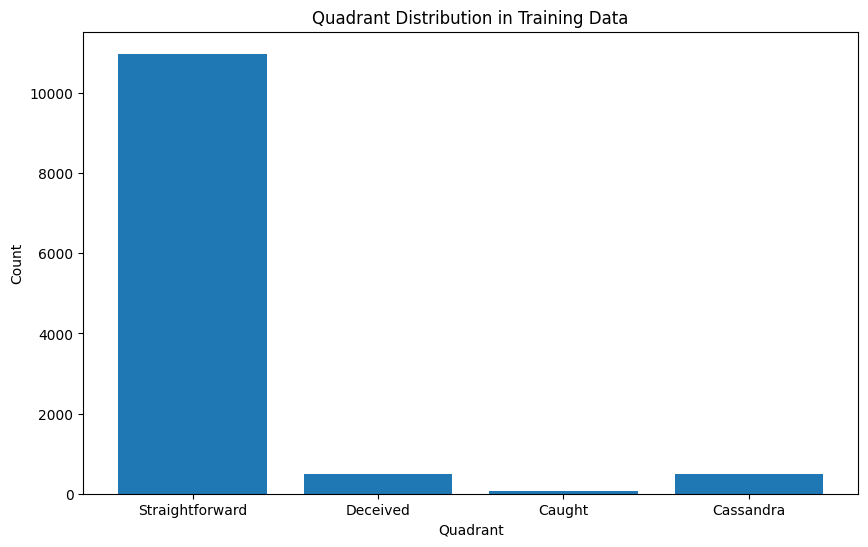

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


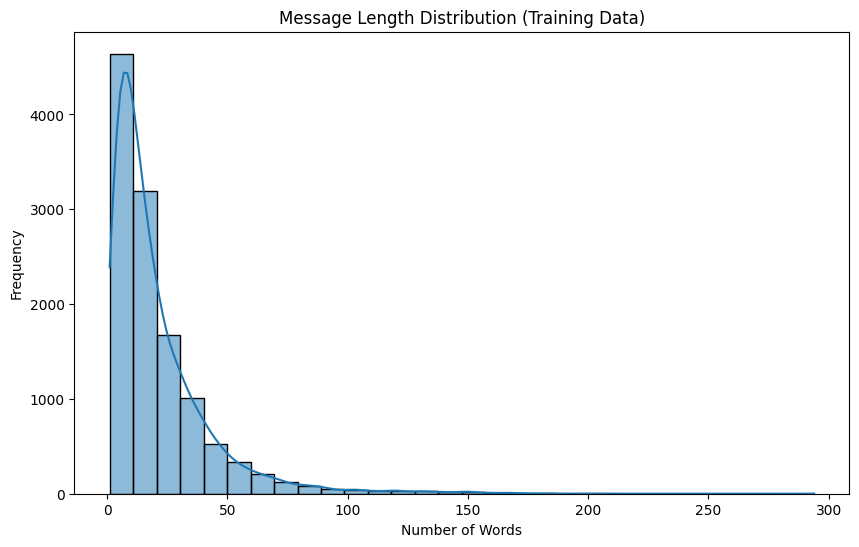

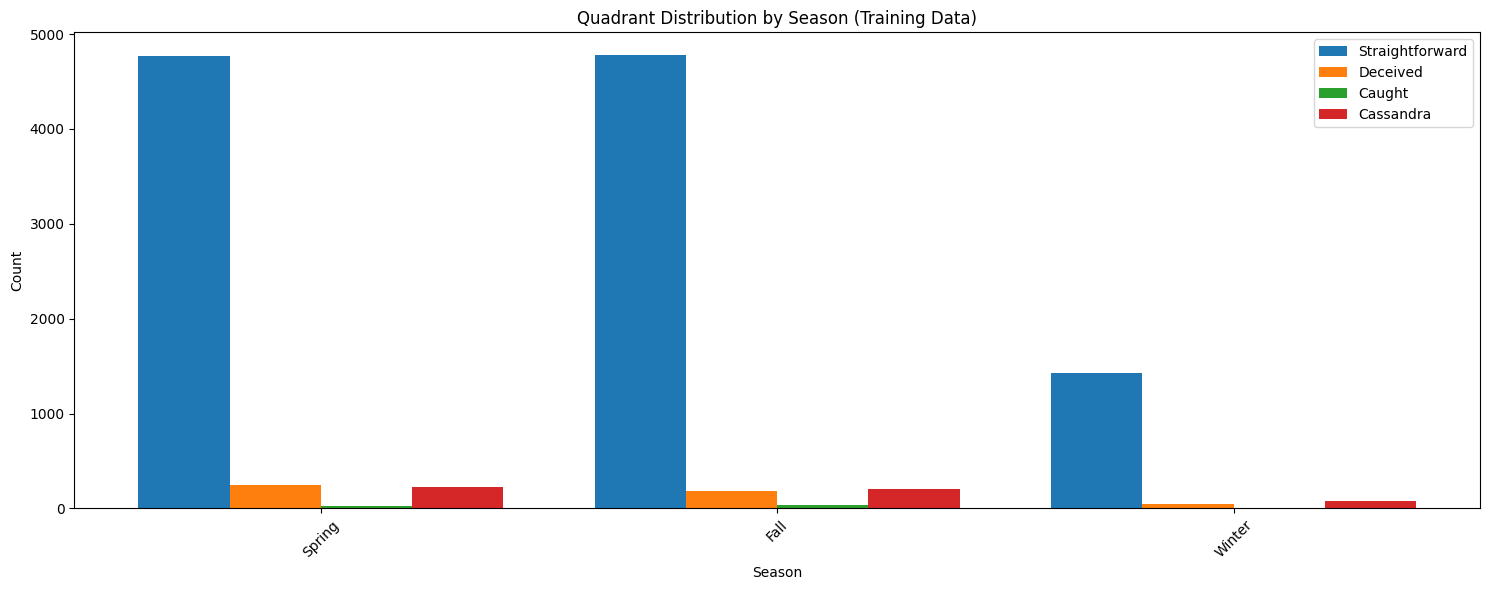

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import json
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import re
import string

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
data_dir = '/kaggle/input/diplomacy/transformers/default/1/Dataset/data'

# Load train, validation, and test datasets
def load_dataset(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_dataset(os.path.join(data_dir, 'train.jsonl'))
validation_data = load_dataset(os.path.join(data_dir, 'validation.jsonl'))
test_data = load_dataset(os.path.join(data_dir, 'test.jsonl'))

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(validation_data)}")
print(f"Test samples: {len(test_data)}")

# Explore the structure of a sample
print(json.dumps(train_data[1], indent=2))

# Modified data exploration functions with quadrant analysis
def explore_data(data):
    quadrant_counts = {
        'Straightforward': 0,
        'Deceived': 0,
        'Caught': 0,
        'Cassandra': 0,
        'Total': 0
    }
    
    message_lengths = []
    season_quadrant = defaultdict(lambda: {'Straightforward': 0, 'Deceived': 0, 'Caught': 0, 'Cassandra': 0})
    player_quadrant = defaultdict(lambda: {'Straightforward': 0, 'Deceived': 0, 'Caught': 0, 'Cassandra': 0})
    
    for sample in data:
        messages = sample['messages']
        sender_labels = sample['sender_labels']
        receiver_labels = sample['receiver_labels']
        seasons = sample['seasons']
        speakers = sample['speakers']
        receivers = sample['receivers']
        
        for i in range(len(messages)):
            msg = messages[i]
            sender_label = sender_labels[i]
            receiver_label = receiver_labels[i]
            
            if receiver_label == "NOANNOTATION":
                continue
            
            quadrant_counts['Total'] += 1
            msg_length = len(msg.split())
            message_lengths.append(msg_length)
            
            season = seasons[i]
            speaker = speakers[i]
            receiver = receivers[i]
            
            if sender_label == True and receiver_label == True:
                quadrant = 'Straightforward'
            elif sender_label == False and receiver_label == True:
                quadrant = 'Deceived'
            elif sender_label == False and receiver_label == False:
                quadrant = 'Caught'
            elif sender_label == True and receiver_label == False:
                quadrant = 'Cassandra'
            
            quadrant_counts[quadrant] += 1
            season_quadrant[season][quadrant] += 1
            interaction = f"{speaker} -> {receiver}"
            player_quadrant[interaction][quadrant] += 1
    
    return quadrant_counts, message_lengths, season_quadrant, player_quadrant

# Perform data exploration on training data
train_quadrant_counts, train_msg_lens, train_season_quadrant, train_player_quadrant = explore_data(train_data)

print("Training Data Quadrant Distribution:")
for key, value in train_quadrant_counts.items():
    print(f"{key}: {value}")

# Visualize quadrant distribution
plt.figure(figsize=(10, 6))
quadrants = ['Straightforward', 'Deceived', 'Caught', 'Cassandra']
values = [train_quadrant_counts[q] for q in quadrants]
plt.bar(quadrants, values)
plt.xlabel('Quadrant')
plt.ylabel('Count')
plt.title('Quadrant Distribution in Training Data')
plt.show()

# Visualize message length distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_msg_lens, bins=30, kde=True)
plt.title('Message Length Distribution (Training Data)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Visualize quadrant distribution by season
seasons = list(train_season_quadrant.keys())
straightforward = [train_season_quadrant[s]['Straightforward'] for s in seasons]
deceived = [train_season_quadrant[s]['Deceived'] for s in seasons]
caught = [train_season_quadrant[s]['Caught'] for s in seasons]
cassandra = [train_season_quadrant[s]['Cassandra'] for s in seasons]

plt.figure(figsize=(15, 6))
x = np.arange(len(seasons))
width = 0.2

plt.bar(x - 1.5*width, straightforward, width, label='Straightforward')
plt.bar(x - 0.5*width, deceived, width, label='Deceived')
plt.bar(x + 0.5*width, caught, width, label='Caught')
plt.bar(x + 1.5*width, cassandra, width, label='Cassandra')

plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Quadrant Distribution by Season (Training Data)')
plt.xticks(x, seasons, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Preprocess the data for modeling
def preprocess_data(data):
    texts = []
    labels = []
    for sample in data:
        messages = sample['messages']
        sender_labels = sample['sender_labels']
        receiver_labels = sample['receiver_labels']
        
        for i in range(len(messages)):
            if receiver_labels[i] != "NOANNOTATION":
                texts.append(messages[i])
                labels.append(0 if sender_labels[i] == False else 1)  # 0 for deceptive, 1 for truthful
    return texts, labels

# Process all datasets
train_texts, train_labels = preprocess_data(train_data)
val_texts, val_labels = preprocess_data(validation_data)
test_texts, test_labels = preprocess_data(test_data)

# Label distribution
print("Label distribution in training data:")
print(f"Deceptive: {sum(1 for l in train_labels if l == 0)}")
print(f"Truthful: {sum(1 for l in train_labels if l == 1)}")

print("\nLabel distribution in validation data:")
print(f"Deceptive: {sum(1 for l in val_labels if l == 0)}")
print(f"Truthful: {sum(1 for l in val_labels if l == 1)}")

print("\nLabel distribution in test data:")
print(f"Deceptive: {sum(1 for l in test_labels if l == 0)}")
print(f"Truthful: {sum(1 for l in test_labels if l == 1)}")

# Text preprocessing
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean all text data
train_texts_clean = [clean_text(text) for text in train_texts]
val_texts_clean = [clean_text(text) for text in val_texts]
test_texts_clean = [clean_text(text) for text in test_texts]

# Tokenization and padding
max_vocab_size = 10000
max_sequence_length = 100

# Initialize tokenizer
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts_clean)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts_clean)
val_sequences = tokenizer.texts_to_sequences(val_texts_clean)
test_sequences = tokenizer.texts_to_sequences(test_texts_clean)

# Pad sequences to uniform length
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Verify the shape
print("Train padded shape:", train_padded.shape)
print("Validation padded shape:", val_padded.shape)
print("Test padded shape:", test_padded.shape)

Label distribution in training data:
Deceptive: 545
Truthful: 11480

Label distribution in validation data:
Deceptive: 50
Truthful: 1233

Label distribution in test data:
Deceptive: 207
Truthful: 2268
Train padded shape: (12025, 100)
Validation padded shape: (1283, 100)
Test padded shape: (2475, 100)


Words more common in deceptive messages:
solo,: deceptive/truthful ratio = 3.33 (deceptive count = 10)
five-way: deceptive/truthful ratio = 3.00 (deceptive count = 6)

Most common deceptive unigrams:
flying: ratio = 5.00, count = 5
selfish: ratio = 4.00, count = 4
excitement: ratio = 4.00, count = 4
“hey,: ratio = 4.00, count = 4
outnumbered: ratio = 4.00, count = 4
eager: ratio = 4.00, count = 4
tipping: ratio = 4.00, count = 4
solo,: ratio = 3.33, count = 10
five-way: ratio = 3.00, count = 6
her.: ratio = 3.00, count = 3
-france: ratio = 3.00, count = 3
helg: ratio = 2.00, count = 2
hug: ratio = 2.00, count = 4
bls: ratio = 2.00, count = 2
ranking: ratio = 2.00, count = 2
scroll: ratio = 2.00, count = 2
bunch,: ratio = 2.00, count = 2
lend: ratio = 2.00, count = 2
sevastopol?: ratio = 2.00, count = 2
business,: ratio = 2.00, count = 2

Most common deceptive bigrams:
- channel: ratio = 5.00, count = 5
play on: ratio = 5.00, count = 5
a five-way: ratio = 5.00, count = 5
preference. i: 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


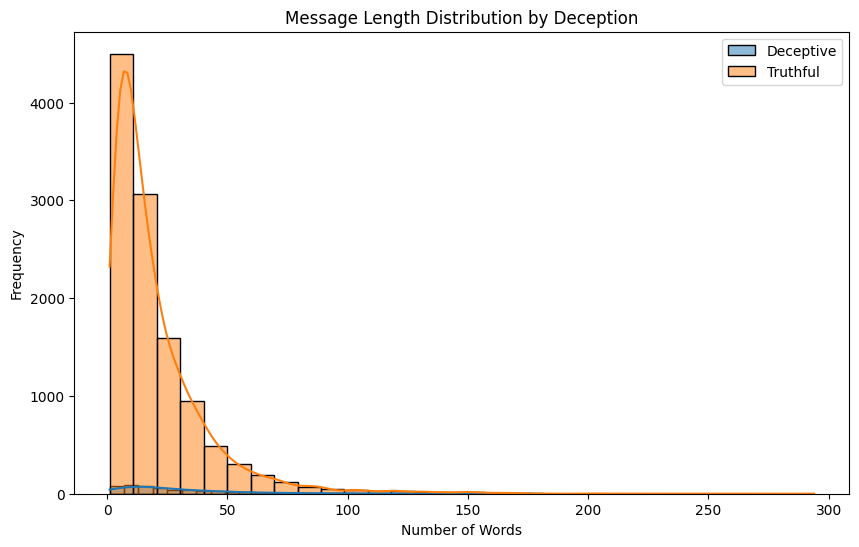


Special Character Analysis:

Punctuation Analysis:


In [7]:
# Linguistic Analysis Block

# Analyze linguistic patterns in deceptive vs truthful messages
def get_word_frequencies(data):
    deceptive_words = defaultdict(int)
    truthful_words = defaultdict(int)
    
    for sample in data:
        messages = sample['messages']
        sender_labels = sample['sender_labels']
        receiver_labels = sample['receiver_labels']
        
        for i in range(len(messages)):
            if receiver_labels[i] != "NOANNOTATION":
                msg = messages[i].lower()
                words = msg.split()
                label = sender_labels[i]
                
                if label == False:
                    for word in words:
                        deceptive_words[word] += 1
                else:
                    for word in words:
                        truthful_words[word] += 1
    
    return deceptive_words, truthful_words

deceptive_words, truthful_words = get_word_frequencies(train_data)

# Find words that are more common in deceptive messages
common_deceptive = []
for word in deceptive_words:
    if deceptive_words[word] > 5 and word in truthful_words:
        ratio = deceptive_words[word] / truthful_words[word]
        if ratio > 2:
            common_deceptive.append((word, ratio, deceptive_words[word]))

# Sort by ratio
common_deceptive.sort(key=lambda x: x[1], reverse=True)

print("Words more common in deceptive messages:")
for word, ratio, count in common_deceptive[:20]:
    print(f"{word}: deceptive/truthful ratio = {ratio:.2f} (deceptive count = {count})")

# Enhanced linguistic analysis with bigrams and trigrams
def get_ngram_frequencies(data, n=1):
    deceptive_counts = defaultdict(int)
    truthful_counts = defaultdict(int)
    
    for sample in data:
        messages = sample['messages']
        sender_labels = sample['sender_labels']
        receiver_labels = sample['receiver_labels']
        
        for i in range(len(messages)):
            if receiver_labels[i] != "NOANNOTATION":
                msg = messages[i].lower()
                words = msg.split()
                label = sender_labels[i]
                
                # Generate n-grams
                ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
                
                for ngram in ngrams:
                    if label == False:
                        deceptive_counts[ngram] += 1
                    else:
                        truthful_counts[ngram] += 1
    
    return deceptive_counts, truthful_counts

# Get unigrams, bigrams, and trigrams
unigram_deceptive, unigram_truthful = get_ngram_frequencies(train_data, n=1)
bigram_deceptive, bigram_truthful = get_ngram_frequencies(train_data, n=2)
trigram_deceptive, trigram_truthful = get_ngram_frequencies(train_data, n=3)

# Function to find common deceptive n-grams
def find_common_deceptive_ngrams(deceptive_counts, truthful_counts, min_count=2, min_ratio=1.5):
    common_deceptive = []
    for ngram in deceptive_counts:
        if deceptive_counts[ngram] >= min_count and ngram in truthful_counts:
            ratio = deceptive_counts[ngram] / truthful_counts[ngram]
            if ratio >= min_ratio:
                common_deceptive.append((ngram, ratio, deceptive_counts[ngram]))
    common_deceptive.sort(key=lambda x: x[1], reverse=True)
    return common_deceptive

# Analyze unigrams
common_deceptive_unigrams = find_common_deceptive_ngrams(unigram_deceptive, unigram_truthful, min_count=2, min_ratio=1.5)
print("\nMost common deceptive unigrams:")
for unigram, ratio, count in common_deceptive_unigrams[:20]:
    print(f"{unigram}: ratio = {ratio:.2f}, count = {count}")

# Analyze bigrams
common_deceptive_bigrams = find_common_deceptive_ngrams(bigram_deceptive, bigram_truthful, min_count=2, min_ratio=1.5)
print("\nMost common deceptive bigrams:")
for bigram, ratio, count in common_deceptive_bigrams[:20]:
    print(f"{bigram}: ratio = {ratio:.2f}, count = {count}")

# Analyze trigrams
common_deceptive_trigrams = find_common_deceptive_ngrams(trigram_deceptive, trigram_truthful, min_count=2, min_ratio=1.5)
print("\nMost common deceptive trigrams:")
for trigram, ratio, count in common_deceptive_trigrams[:20]:
    print(f"{trigram}: ratio = {ratio:.2f}, count = {count}")

# Message length analysis
def message_length_analysis(data):
    deceptive_lengths = []
    truthful_lengths = []
    
    for sample in data:
        messages = sample['messages']
        sender_labels = sample['sender_labels']
        receiver_labels = sample['receiver_labels']
        
        for i in range(len(messages)):
            if receiver_labels[i] != "NOANNOTATION":
                msg_length = len(messages[i].split())
                label = sender_labels[i]
                
                if label == False:
                    deceptive_lengths.append(msg_length)
                else:
                    truthful_lengths.append(msg_length)
    
    return deceptive_lengths, truthful_lengths

deceptive_lengths, truthful_lengths = message_length_analysis(train_data)

print("\nMessage Length Analysis:")
print(f"Deceptive messages average length: {np.mean(deceptive_lengths):.2f} words")
print(f"Truthful messages average length: {np.mean(truthful_lengths):.2f} words")

# Visualize message length distribution
plt.figure(figsize=(10, 6))
sns.histplot(deceptive_lengths, bins=30, kde=True, label='Deceptive')
sns.histplot(truthful_lengths, bins=30, kde=True, label='Truthful')
plt.title('Message Length Distribution by Deception')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Special character analysis
def special_character_analysis(data):
    deceptive_chars = defaultdict(int)
    truthful_chars = defaultdict(int)
    
    for sample in data:
        messages = sample['messages']
        sender_labels = sample['sender_labels']
        receiver_labels = sample['receiver_labels']
        
        for i in range(len(messages)):
            if receiver_labels[i] != "NOANNOTATION":
                msg = messages[i]
                label = sender_labels[i]
                
                for char in msg:
                    if not char.isalnum() and char != ' ':
                        if label == False:
                            deceptive_chars[char] += 1
                        else:
                            truthful_chars[char] += 1
    
    return deceptive_chars, truthful_chars

deceptive_chars, truthful_chars = special_character_analysis(train_data)

print("\nSpecial Character Analysis:")
for char in deceptive_chars:
    if deceptive_chars[char] > 5 and char in truthful_chars:
        ratio = deceptive_chars[char] / truthful_chars[char]
        if ratio > 2:
            print(f"Character '{char}': deceptive/truthful ratio = {ratio:.2f} (deceptive count = {deceptive_chars[char]})")

# Punctuation analysis
def punctuation_analysis(data):
    deceptive_punct = defaultdict(int)
    truthful_punct = defaultdict(int)
    
    for sample in data:
        messages = sample['messages']
        sender_labels = sample['sender_labels']
        receiver_labels = sample['receiver_labels']
        
        for i in range(len(messages)):
            if receiver_labels[i] != "NOANNOTATION":
                msg = messages[i]
                label = sender_labels[i]
                
                for char in msg:
                    if char in string.punctuation:
                        if label == False:
                            deceptive_punct[char] += 1
                        else:
                            truthful_punct[char] += 1
    
    return deceptive_punct, truthful_punct

deceptive_punct, truthful_punct = punctuation_analysis(train_data)

print("\nPunctuation Analysis:")
for punct in deceptive_punct:
    if deceptive_punct[punct] > 5 and punct in truthful_punct:
        ratio = deceptive_punct[punct] / truthful_punct[punct]
        if ratio > 2:
            print(f"Punctuation '{punct}': deceptive/truthful ratio = {ratio:.2f} (deceptive count = {deceptive_punct[punct]})")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 100, 128)       │      1,280,000 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 100, 128)       │         98,816 │ embedding_5[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_4 (Attention)   │ (None, 100, 128)       │              0 │ bidirectional_5[0][0], │
│                           │                        │                │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 12800)          │              0 │ attention_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │        819,264 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │             65 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,198,145 (8.39 MB)

 Trainable params: 2,198,145 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9457 - f1_score_metric: 0.9695 - loss: 0.2234 - val_accuracy: 0.9610 - val_f1_score_metric: 0.9801 - val_loss: 0.1804
Epoch 2/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9563 - f1_score_metric: 0.9772 - loss: 0.1948 - val_accuracy: 0.9610 - val_f1_score_metric: 0.9801 - val_loss: 0.1620
Epoch 3/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9574 - f1_score_metric: 0.9737 - loss: 0.1654 - val_accuracy: 0.9610 - val_f1_score_metric: 0.9801 - val_loss: 0.1553
Epoch 4/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9608 - f1_score_metric: 0.9664 - loss: 0.1398 - val_accuracy: 0.9595 - val_f1_score_metric: 0.9786 - val_loss: 0.2238
Epoch 5/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9699 - f1_score_metric: 0.9666 - loss: 0.1084 - val_accuracy: 0.9571 - val_f1_score_metric: 0.9768 - val_loss: 0.2497
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9373 - f1_score_metri

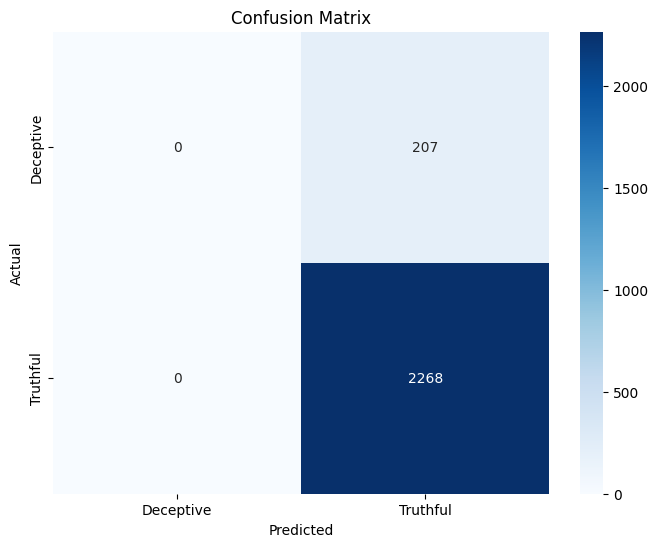

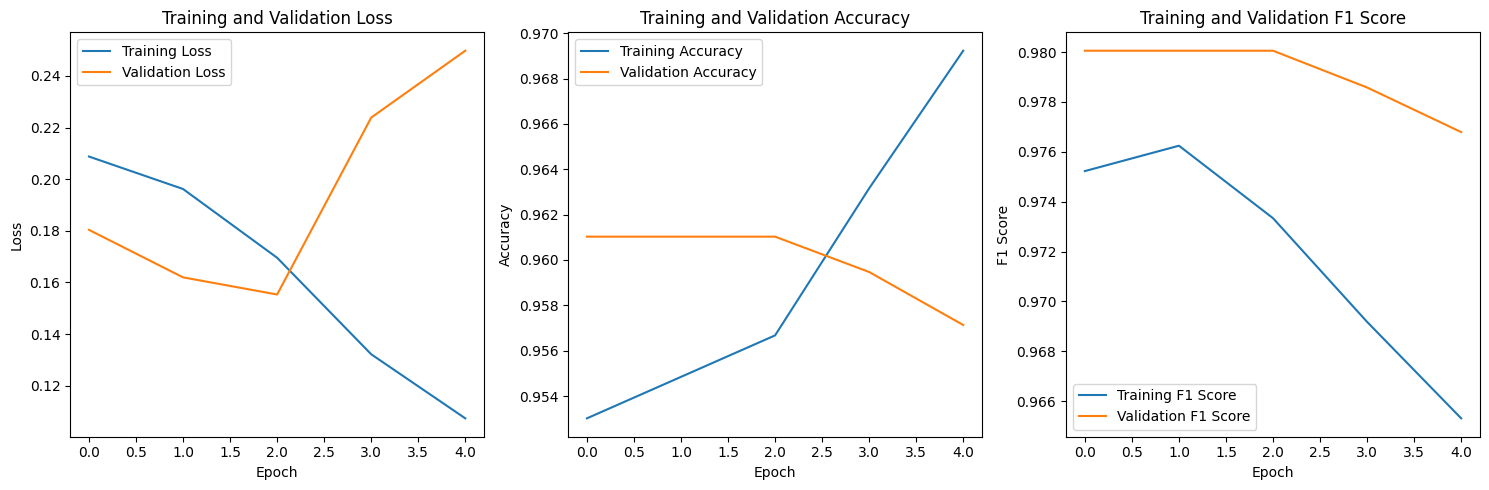


Macro F1 Score: 0.4782
Micro F1 Score: 0.8764


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


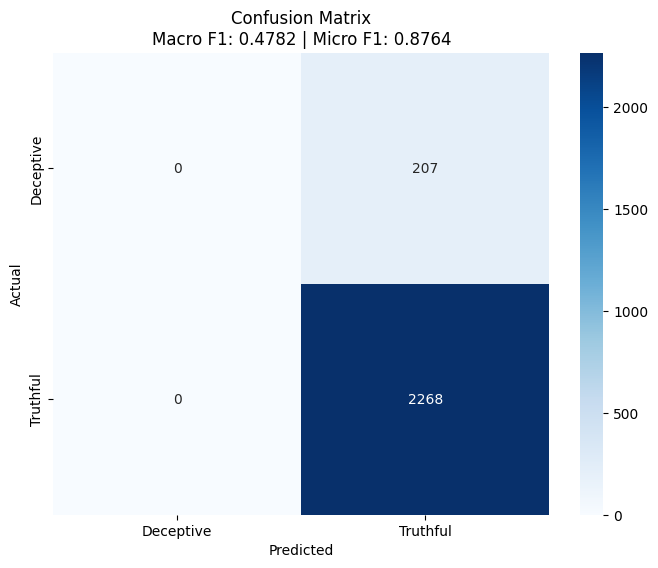

In [12]:
# Define the Bi-LSTM with Attention model
def create_bi_lstm_attention_model(max_vocab_size, embedding_dim, lstm_units, max_sequence_length):
    inputs = Input(shape=(max_sequence_length,))
    
    # Embedding layer
    embedding = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(inputs)
    
    # Bidirectional LSTM
    lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
    
    # Attention mechanism
    attention = tf.keras.layers.Attention()([lstm_layer, lstm_layer])
    attention = Flatten()(attention)
    
    # Classification layers
    dense = Dense(64, activation='relu')(attention)
    dropout = Dropout(0.5)(dense)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Model parameters
embedding_dim = 128
lstm_units = 64

# Create the model
model = create_bi_lstm_attention_model(max_vocab_size, embedding_dim, lstm_units, max_sequence_length)

# Custom F1 Score metric
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

# Compile the model with custom F1 score metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/kaggle/working/model_epoch_{epoch:02d}.keras',
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    mode='auto'
)
best_model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

# Train the model
history = model.fit(
    train_padded, 
    np.array(train_labels, dtype=np.float32),
    batch_size=32,
    epochs=10,
    validation_data=(val_padded, np.array(val_labels, dtype=np.float32)),
    callbacks=[early_stopping, model_checkpoint, best_model_checkpoint]
)

# Evaluate on test data
test_loss, test_accuracy, test_f1 = model.evaluate(test_padded, np.array(test_labels, dtype=np.float32))
print(f'\nTest accuracy: {test_accuracy:.4f}')
print(f'Test F1 score: {test_f1:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Load the best model
best_model = load_model('/kaggle/working/best_model.keras', custom_objects={'f1_score_metric': f1_score_metric})

# Evaluate best model on test data
best_test_loss, best_test_accuracy, best_test_f1 = best_model.evaluate(test_padded, np.array(test_labels, dtype=np.float32))
print(f'\nBest model - Test accuracy: {best_test_accuracy:.4f}')
print(f'Best model - Test F1 score: {best_test_f1:.4f}')
print(f'Best model - Test loss: {best_test_loss:.4f}')

# Generate predictions
test_predictions = best_model.predict(test_padded)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Calculate evaluation metrics
precision = precision_score(test_labels, test_predictions_binary)
recall = recall_score(test_labels, test_predictions_binary)
f1 = f1_score(test_labels, test_predictions_binary)
conf_matrix = confusion_matrix(test_labels, test_predictions_binary)

print(f'\nPrecision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Deceptive', 'Truthful'], 
            yticklabels=['Deceptive', 'Truthful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# F1 Score plot
plt.subplot(1, 3, 3)
plt.plot(history.history['f1_score_metric'], label='Training F1 Score')
plt.plot(history.history['val_f1_score_metric'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Training and Validation F1 Score')

plt.tight_layout()
plt.show()

# Calculate macro and micro F1 scores
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(test_labels, test_predictions_binary, target_names=['Deceptive', 'Truthful'], output_dict=True)

# Extract macro and micro F1 scores
macro_f1 = class_report['macro avg']['f1-score']
micro_f1 = class_report['weighted avg']['f1-score']

print(f'\nMacro F1 Score: {macro_f1:.4f}')
print(f'Micro F1 Score: {micro_f1:.4f}')

# Add these to the confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Deceptive', 'Truthful'], 
            yticklabels=['Deceptive', 'Truthful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nMacro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f}')
plt.show()

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Actual Lie - Precision: 0.9164
Actual Lie - Recall: 1.0000
Actual Lie - F1 Score: 0.9564
Actual Lie - Macro F1 Score: 0.4782
Actual Lie - Micro F1 Score: 0.9164


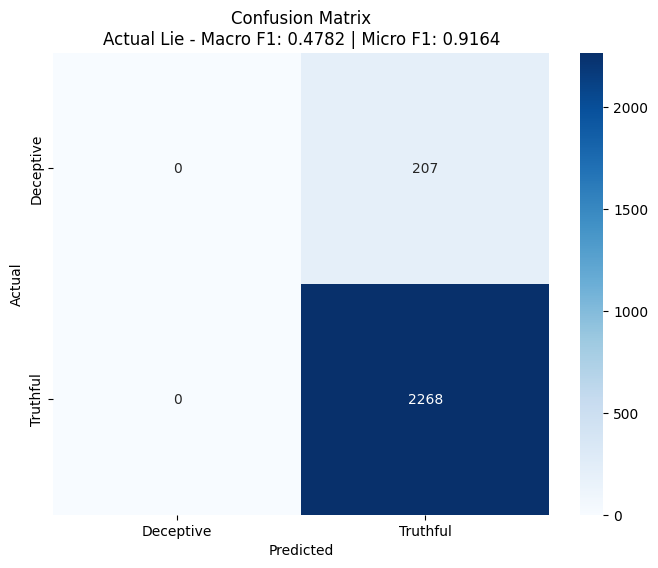

In [14]:
# Generate predictions
test_predictions = best_model.predict(test_padded)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Calculate evaluation metrics for actual lies
precision_actual = precision_score(test_labels, test_predictions_binary)
recall_actual = recall_score(test_labels, test_predictions_binary)
f1_actual = f1_score(test_labels, test_predictions_binary)
f1_macro_actual = f1_score(test_labels, test_predictions_binary, average='macro')
f1_micro_actual = f1_score(test_labels, test_predictions_binary, average='micro')

print(f'\nActual Lie - Precision: {precision_actual:.4f}')
print(f'Actual Lie - Recall: {recall_actual:.4f}')
print(f'Actual Lie - F1 Score: {f1_actual:.4f}')
print(f'Actual Lie - Macro F1 Score: {f1_macro_actual:.4f}')
print(f'Actual Lie - Micro F1 Score: {f1_micro_actual:.4f}')

# For suspected lies, you'll need a separate dataset or labels
# Assuming you have suspected_labels available
# precision_suspected = precision_score(suspected_true_labels, suspected_predictions)
# recall_suspected = recall_score(suspected_true_labels, suspected_predictions)
# f1_suspected = f1_score(suspected_true_labels, suspected_predictions)
# f1_macro_suspected = f1_score(suspected_true_labels, suspected_predictions, average='macro')
# f1_micro_suspected = f1_score(suspected_true_labels, suspected_predictions, average='micro')

# Update confusion matrix plot with actual lie metrics
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Deceptive', 'Truthful'], 
            yticklabels=['Deceptive', 'Truthful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nActual Lie - Macro F1: {f1_macro_actual:.4f} | Micro F1: {f1_micro_actual:.4f}')
plt.show()

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Actual Lies - Precision: 0.9164
Actual Lies - Recall: 1.0000
Actual Lies - F1 Score: 0.9564
Actual Lies - Macro F1: 0.4782
Actual Lies - Lie F1: 0.0000


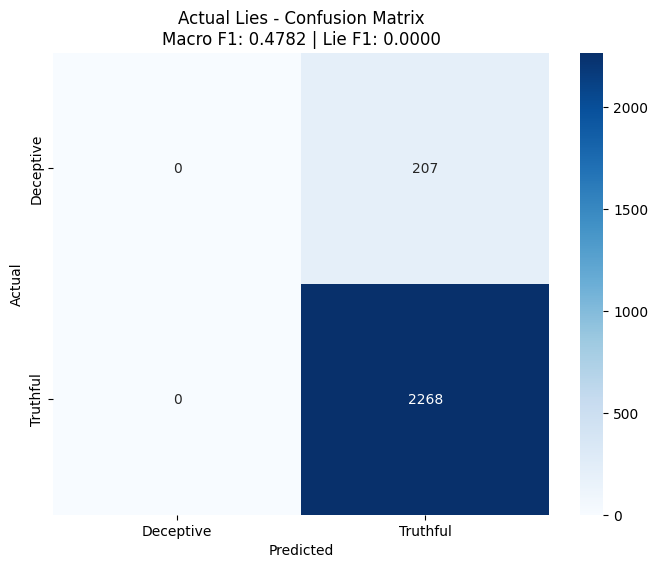

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Suspected Lies - Precision: 0.9333
Suspected Lies - Recall: 1.0000
Suspected Lies - F1 Score: 0.9655
Suspected Lies - Macro F1: 0.4828
Suspected Lies - Lie F1: 0.0000


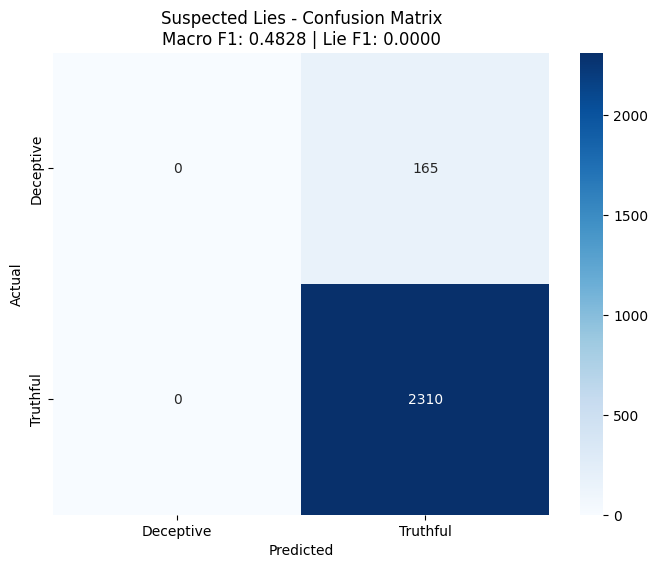

In [17]:
# Generate predictions for test data
test_predictions = best_model.predict(test_padded)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Evaluate for actual lies (using sender_labels)
actual_labels = test_labels  # Assuming test_labels are sender_labels

# Calculate evaluation metrics for actual lies
precision_actual = precision_score(actual_labels, test_predictions_binary)
recall_actual = recall_score(actual_labels, test_predictions_binary)
f1_actual = f1_score(actual_labels, test_predictions_binary)
f1_macro_actual = f1_score(actual_labels, test_predictions_binary, average='macro')
f1_lie_actual = f1_score(actual_labels, test_predictions_binary, average='binary', pos_label=0)  # Lie F1 (deceptive class)

print(f'\nActual Lies - Precision: {precision_actual:.4f}')
print(f'Actual Lies - Recall: {recall_actual:.4f}')
print(f'Actual Lies - F1 Score: {f1_actual:.4f}')
print(f'Actual Lies - Macro F1: {f1_macro_actual:.4f}')
print(f'Actual Lies - Lie F1: {f1_lie_actual:.4f}')

# Create confusion matrix for actual lies
conf_matrix_actual = confusion_matrix(actual_labels, test_predictions_binary)

# Plot confusion matrix for actual lies
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_actual, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Deceptive', 'Truthful'], 
            yticklabels=['Deceptive', 'Truthful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Actual Lies - Confusion Matrix\nMacro F1: {f1_macro_actual:.4f} | Lie F1: {f1_lie_actual:.4f}')
plt.show()

# Evaluate for suspected lies (using receiver_labels)
# Create a dataset using receiver_labels
def preprocess_suspected_data(data):
    texts = []
    labels = []
    for sample in data:
        messages = sample['messages']
        sender_labels = sample['sender_labels']
        receiver_labels = sample['receiver_labels']
        
        for i in range(len(messages)):
            if receiver_labels[i] != "NOANNOTATION":
                texts.append(messages[i])
                labels.append(0 if receiver_labels[i] == False else 1)  # 0 for deceptive, 1 for truthful
    return texts, labels

# Process test data for suspected lies
suspected_texts, suspected_labels = preprocess_suspected_data(test_data)

# Clean and preprocess suspected data
suspected_texts_clean = [clean_text(text) for text in suspected_texts]
suspected_sequences = tokenizer.texts_to_sequences(suspected_texts_clean)
suspected_padded = pad_sequences(suspected_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Generate predictions for suspected lies
suspected_predictions = best_model.predict(suspected_padded)
suspected_predictions_binary = (suspected_predictions > 0.5).astype(int)

# Calculate evaluation metrics for suspected lies
precision_suspected = precision_score(suspected_labels, suspected_predictions_binary)
recall_suspected = recall_score(suspected_labels, suspected_predictions_binary)
f1_suspected = f1_score(suspected_labels, suspected_predictions_binary)
f1_macro_suspected = f1_score(suspected_labels, suspected_predictions_binary, average='macro')
f1_lie_suspected = f1_score(suspected_labels, suspected_predictions_binary, average='binary', pos_label=0)  # Lie F1 (deceptive class)

print(f'\nSuspected Lies - Precision: {precision_suspected:.4f}')
print(f'Suspected Lies - Recall: {recall_suspected:.4f}')
print(f'Suspected Lies - F1 Score: {f1_suspected:.4f}')
print(f'Suspected Lies - Macro F1: {f1_macro_suspected:.4f}')
print(f'Suspected Lies - Lie F1: {f1_lie_suspected:.4f}')

# Create confusion matrix for suspected lies
conf_matrix_suspected = confusion_matrix(suspected_labels, suspected_predictions_binary)

# Plot confusion matrix for suspected lies
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_suspected, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Deceptive', 'Truthful'], 
            yticklabels=['Deceptive', 'Truthful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Suspected Lies - Confusion Matrix\nMacro F1: {f1_macro_suspected:.4f} | Lie F1: {f1_lie_suspected:.4f}')
plt.show()